In [1]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor1/clones/knn_kparam_3"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_3/clonalShift_method_clones/top/"
cloneID_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_3/clonalShift_method_clones/cloneIDs.txt"

ntop_clones = 10
p_thresh = 0.1

In [2]:
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm
from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 
import seaborn as sns
import matplotlib.pyplot as plt
from src import clonal_shifts as cs
from icecream import ic
from mplh import cluster_help as ch
plt.rcParams['svg.fonttype'] = 'none'

fig_utils from mplh


In [3]:
with open(cloneID_f, "r") as f:
    cloneIDs = f.readlines()
cloneIDs = [x.strip() for x in cloneIDs]
cloneIDs

top_cloneIDs = cloneIDs[:ntop_clones]
top_cloneIDs

['1_4', '1_37', '1_18', '1_24', '1_15', '1_5', '1_6', '1_8', '1_10', '1_11']

In [4]:
#cells_meta = pd.read_csv(cells_meta_f, sep="\t")

In [5]:
noInput_hyper = pd.read_csv(join(indir, "noInput_hypergeo_pvals.csv"),  index_col=0)
noIn_shuffle_df = pd.read_csv(join(indir, "noInput_shuffle_results_pvals.csv"), index_col=0)

input_hyper = pd.read_csv(join(indir, "input_hypergeo_pvals.csv"), index_col=0)
input_shuffle_df = pd.read_csv(join(indir, "input_shuffle_results_pvals.csv"), index_col=0)

input_shuffle_df

,index,variable,value,method
0,1_0,CLP,0.656941,global_all
1,1_1,CLP,0.964322,global_all
2,1_10,CLP,0.271043,global_all
3,1_11,CLP,0.969600,global_all
4,1_12,CLP,0.931594,global_all
...,...,...,...,...
485,1_5,neutrophil B,1.000000,clone_min
486,1_6,neutrophil B,1.000000,clone_min
487,1_7,neutrophil B,0.193000,clone_min
488,1_8,neutrophil B,1.000000,clone_min


In [6]:
def create_pval(clone_d, hyper_key, shuffle_key, clustIDs):
    pval_df = pd.DataFrame(columns = ["hypergeo", "global_min", "clone_min", "clone_all", "global_all"],
                           index=clustIDs)
    if clone_d[shuffle_key] is None:
        if clone_d[hyper_key] is not None:
            pval_df.loc[clone_d[hyper_key].index, "hypergeo"] = clone_d[hyper_key]
            print('pval_df')
        else:
            print("no sig")
    else:
        shuff_df = clone_d[shuffle_key].pivot(index="variable", columns="method", values="value")
        shuff_df
        pval_df.loc[shuff_df.index, shuff_df.columns] = shuff_df

        if clone_d[hyper_key] is not None:
            pval_df.loc[clone_d[hyper_key].index, "hypergeo"] = clone_d[hyper_key]
    
    #pval_df.fillna(1)     
    return pval_df


def run_ind_clone(clone_id):
    print('clone_id', clone_id)
    clone_d = {}
    if clone_id in noInput_hyper.index:
        clone_d["noIn_hyper"] = noInput_hyper.loc[clone_id]
    else: 
        clone_d["noIn_hyper"] = None
    
    if clone_id in noIn_shuffle_df["index"].values:
        clone_d["noIn_shuffle"] = noIn_shuffle_df.loc[noIn_shuffle_df["index"]==clone_id]
    else:
        clone_d["noIn_shuffle"] = None
        
        
    if clone_id in input_hyper.index:
        clone_d["input_hyper"] = input_hyper.loc[clone_id]
    else: 
        clone_d["input_hyper"] = None
            
    if clone_id in input_shuffle_df["index"].values:
        clone_d["input_shuffle"] = input_shuffle_df.loc[input_shuffle_df["index"]==clone_id]
    else:
        clone_d["input_shuffle"] = None
            
    
    clone_d['noIn_shuffle']
    clone_d['noIn_hyper']
    
    set_input_hyper = clone_d['input_hyper'].index if clone_d['input_hyper'] is not None else set()
    set_noInput_hyper = clone_d['noIn_hyper'].index if clone_d['noIn_hyper'] is not None else set()

    set_input_shuffle = clone_d['input_shuffle']["variable"].values if clone_d['input_shuffle'] is not None else set()
    set_noInput_shuffle = clone_d['noIn_shuffle']["variable"].values if clone_d['noIn_shuffle'] is not None else set()

    
    clustIDs = set(set_input_hyper).union(set_noInput_hyper)
    clustIDs = clustIDs.union(set_noInput_shuffle).union(set_input_shuffle)
    
    noIn_pval_df = create_pval(clone_d, hyper_key="noIn_hyper",shuffle_key="noIn_shuffle", clustIDs=clustIDs)
    input_pval_df = create_pval(clone_d, hyper_key="input_hyper",shuffle_key="input_shuffle", clustIDs=clustIDs)
    pval_df = pd.merge(input_pval_df, noIn_pval_df, left_index=True, right_index=True, 
                       how="outer", suffixes=("_Input", "_Cultured"))

    ## Sort clusters by global_min, hypergeo, 
    pval_df = pval_df.fillna(1).sort_values(["global_min_Input", "hypergeo_Input", "clone_min_Input","global_min_Cultured", "hypergeo_Cultured",  "clone_min_Cultured"])
#     plt.close()
    return pval_df

In [7]:
pval_d = {}
for c_id in top_cloneIDs:
    pval_d[c_id] = run_ind_clone(c_id)

clone_id 1_4
clone_id 1_37
no sig
clone_id 1_18
clone_id 1_24
clone_id 1_15
clone_id 1_5
clone_id 1_6
clone_id 1_8
clone_id 1_10
clone_id 1_11


In [8]:
sig_input_d = []
sig_cultured_d = []

for i in pval_d:
    print(i)
    curr_input_cols = pval_d[i].columns[pval_d[i].columns.str.contains("_Input")]
    curr_cultured_cols = pval_d[i].columns[pval_d[i].columns.str.contains("_Cultured")]
    curr_cultured_cols

    pval_bin = (pval_d[i]<p_thresh)
    
    curr_sig_input = pd.Series(index=pval_bin.index, name=i)
    curr_sig_input.loc[:] = 0
    
    curr_sig_input.loc[(pval_bin["hypergeo_Input"]==True)] = 1
    curr_sig_input.loc[(pval_bin["hypergeo_Input"]==True) & (pval_bin["global_all_Input"]==True) ] = 2
    curr_sig_input.loc[(pval_bin["hypergeo_Input"]==True) & (pval_bin["global_all_Input"]==True)
                      & (pval_bin["clone_min_Input"]==True)] = 3
    curr_sig_input.loc[(pval_bin["hypergeo_Input"]==True) & (pval_bin["global_all_Input"]==True)
                      & (pval_bin["clone_min_Input"]==True) & (pval_bin["global_min_Input"]==True)] = 4    
#     curr_sig_input.loc[pval_bin["global_all_Input"]==True] += 1
#     curr_sig_input.loc[pval_bin["clone_min_Input"]==True] += 1
#     curr_sig_input.loc[pval_bin["global_min_Input"]==True] += 1

    sig_input_d.append(pd.DataFrame(curr_sig_input))
    
    curr_sig_cultured = pd.Series(index=pval_bin.index, name=i)
    curr_sig_cultured.loc[:] = 0
#     curr_sig_cultured.loc[pval_bin["hypergeo_Cultured"]==True] = 1
#     curr_sig_cultured.loc[pval_bin["global_all_Cultured"]==True] += 1
#     curr_sig_cultured.loc[pval_bin["clone_min_Cultured"]==True] += 1
#     curr_sig_cultured.loc[pval_bin["global_min_Cultured"]==True] += 1
    curr_sig_cultured.loc[(pval_bin["hypergeo_Cultured"]==True)] = 1
    curr_sig_cultured.loc[(pval_bin["hypergeo_Cultured"]==True) & (pval_bin["global_all_Cultured"]==True)] = 2
    curr_sig_cultured.loc[(pval_bin["hypergeo_Cultured"]==True) & (pval_bin["global_all_Cultured"]==True)
                           & (pval_bin["clone_min_Cultured"]==True)] = 3  
    curr_sig_cultured.loc[(pval_bin["hypergeo_Cultured"]==True) & (pval_bin["global_all_Cultured"]==True)
                          & (pval_bin["clone_min_Cultured"]==True) & (pval_bin["global_min_Cultured"]==True)] = 4       
        
    sig_cultured_d.append(pd.DataFrame(curr_sig_cultured))

sig_input_df = pd.concat(sig_input_d, axis=1).fillna(0)
sig_input_df

sig_cultured_df = pd.concat(sig_cultured_d, axis=1).fillna(0)
sig_cultured_df

# merge_sig_df = sig_input_df.transpose()
# merge_sig_df

melt_sig_input = sig_input_df.transpose().reset_index().melt(id_vars='index')
melt_sig_input["cond"] = "input"
melt_sig_cultured = sig_cultured_df.transpose().reset_index().melt(id_vars='index')
melt_sig_cultured["cond"] = "cultured"
merge_sig_df = pd.concat((melt_sig_input, melt_sig_cultured))
merge_sig_df

1_4
1_37
1_18
1_24
1_15
1_5
1_6
1_8
1_10
1_11


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == "":
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,index,variable,value,cond
0,1_4,macrophage,0.0,input
1,1_37,macrophage,0.0,input
2,1_18,macrophage,0.0,input
3,1_24,macrophage,0.0,input
4,1_15,macrophage,0.0,input
...,...,...,...,...
135,1_5,eosonophil,0.0,cultured
136,1_6,eosonophil,0.0,cultured
137,1_8,eosonophil,0.0,cultured
138,1_10,eosonophil,0.0,cultured


In [9]:
def plot_hyper_sig(data, **kwargs):
    #print(data.head())
    data.pivot(index="variable", columns="index", values="value").plot.bar(ax=plt.gca())
    sns.heatmap(data.pivot(index="variable", columns="index", values="value"), ax=plt.gca(),
               vmax=4, vmin=0)
    return


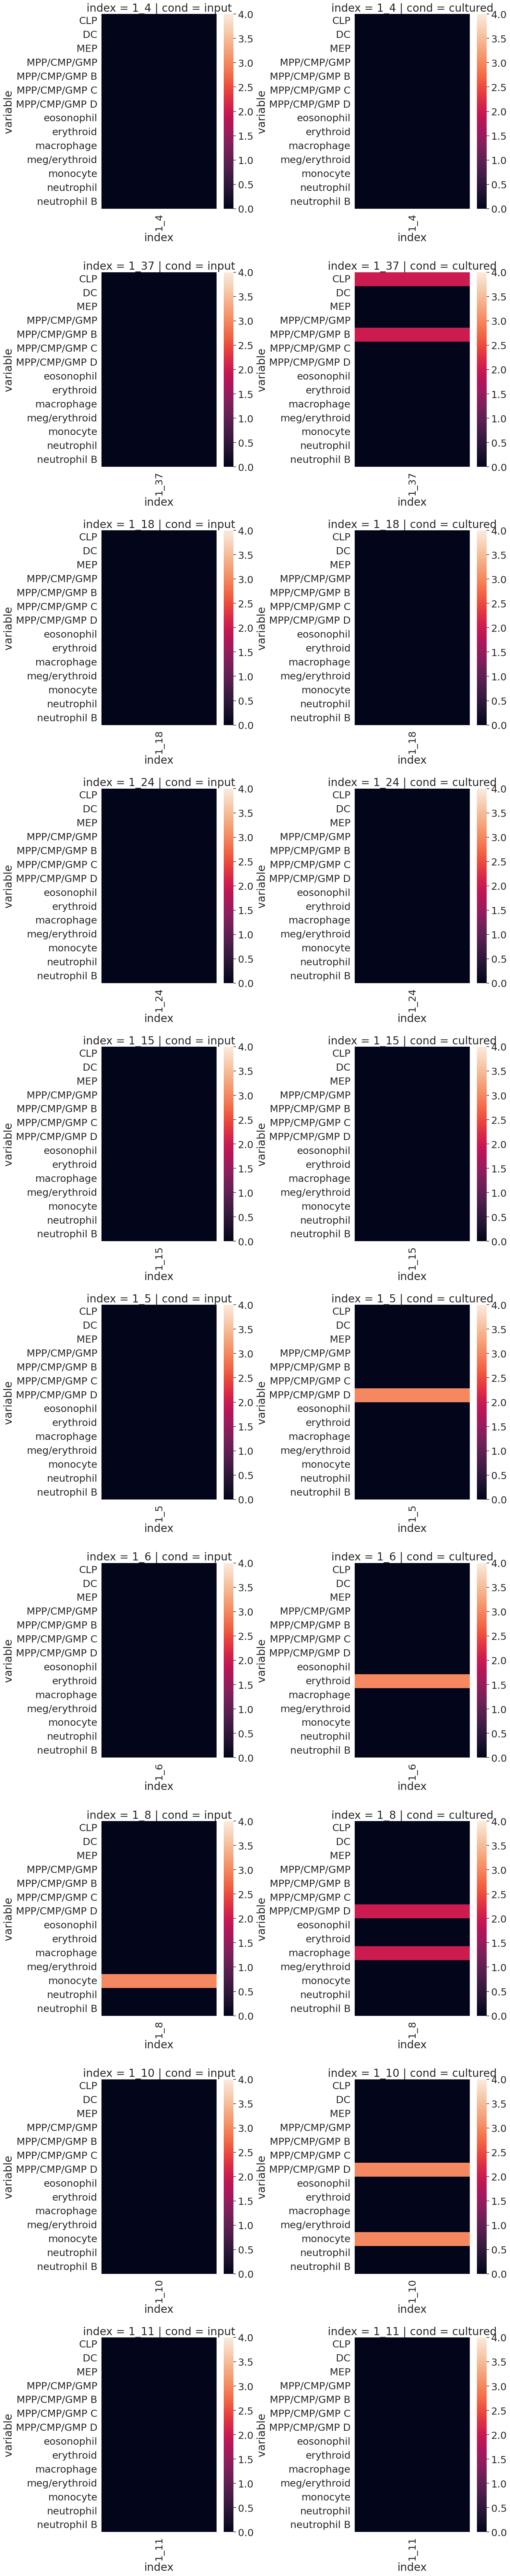

In [15]:
#figsize=(len(top_cloneIDs)*4*(4/3), len(top_cloneIDs)*4)
sns.set(font_scale=2)
g = sns.FacetGrid(data=merge_sig_df, col="cond", row='index',
                  row_order=top_cloneIDs, col_order=["input", "cultured"],
                  sharex=False, sharey=False, height=8, aspect=1)
g.map_dataframe(plot_hyper_sig)
#g.fig.savefig(fname=join(outdir, f"top{ntop_clones}_sig_hypergeo.pdf"), dpi=500, bbox_inches='tight', pad_inches=0.5)

g.fig.savefig(fname=join(outdir, f"top{ntop_clones}_sig_hypergeo.svg"), bbox_inches='tight', pad_inches=0.5)
# g = sns.FacetGrid(data=sig_input_df.reset_index().melt(id_vars='index'), col="variable", col_wrap=1,
#                  sharex=False, sharey=False, height=4, aspect=2)
# g.map_dataframe(plot_hyper_sig)
# g.fig.savefig(fname=join(outdir, f"top{ntop_clones}_sig_hypergeo.pdf"), dpi=500, bbox_inches='tight', pad_inches=0.5)


In [11]:
# pval_bin = (pval_d[i]<p_thresh)
# curr_sig_noInput = pd.Series(index=pval_bin.index)
# curr_sig_noInput.loc[:] = 0
# curr_sig_noInput.loc[pval_bin["hypergeo_Input"]==True] = 1
# curr_sig_noInput.loc[pval_bin["global_all_Input"]==True] += 1
# curr_sig_noInput.loc[pval_bin["clone_min_Input"]==True] += 1
# curr_sig_noInput.loc[pval_bin["global_min_Input"]==True] += 1

# # sig = sig.astype(int) + (x.loc["global_all"]).astype(int)
# # sig = sig.astype(int) + (x.loc["clone_min"]).astype(int)
# # sig = sig.astype(int) + (x.loc["global_min"]).astype(int)
# # sig
# #pval_bin["hypergeo_Input"]
# curr_sig_noInput


# def run_ind_clone(clone_id, p_thresh=0.1):
#     print('clone_id', clone_id)
    
#     noIn_sig_score = pd.Series(index=noInput_hyper.columns, name=clone_id)
#     in_sig_score = 0
    
    
#     clone_d = {}
#     if clone_id in noInput_hyper.index:
#         clone_d["noIn_hyper"] = noInput_hyper.loc[clone_id]
#         noIn_sig_score.loc[(noInput_hyper.loc[clone_id] < p_thresh)] = 1
# #         if noInput_hyper.loc[clone_id] < p_thresh:
# #             noIn_sig_score += 1

#     if clone_id in noInput_hyper.index:
#         curr_noIn_shuffle = noInput_hyper.loc[clone_id]
#         noIn_sig_score.loc[(noInput_hyper.loc[clone_id] < p_thresh)] = 1
    
#     if clone_id in noIn_shuffle_df["index"].values:
#         clone_d["noIn_shuffle"] = noIn_shuffle_df.loc[noIn_shuffle_df["index"]==clone_id]
#     else:
#         clone_d["noIn_shuffle"] = None
        
        
#     if clone_id in input_hyper.index:
#         clone_d["input_hyper"] = input_hyper.loc[clone_id]
#     else: 
#         clone_d["input_hyper"] = None
            
#     if clone_id in input_shuffle_df["index"].values:
#         clone_d["input_shuffle"] = input_shuffle_df.loc[input_shuffle_df["index"]==clone_id]
#     else:
#         clone_d["input_shuffle"] = None
            
    
#     clone_d['noIn_shuffle']
#     clone_d['noIn_hyper']
    
#     set_input_hyper = clone_d['input_hyper'].index if clone_d['input_hyper'] is not None else set()
#     set_noInput_hyper = clone_d['noIn_hyper'].index if clone_d['noIn_hyper'] is not None else set()

#     set_input_shuffle = clone_d['input_shuffle']["variable"].values if clone_d['input_shuffle'] is not None else set()
#     set_noInput_shuffle = clone_d['noIn_shuffle']["variable"].values if clone_d['noIn_shuffle'] is not None else set()

    
#     clustIDs = set(set_input_hyper).union(set_noInput_hyper)
#     clustIDs = clustIDs.union(set_noInput_shuffle).union(set_input_shuffle)
    
#     noIn_pval_df = create_pval(clone_d, hyper_key="noIn_hyper",shuffle_key="noIn_shuffle", clustIDs=clustIDs)
#     input_pval_df = create_pval(clone_d, hyper_key="input_hyper",shuffle_key="input_shuffle", clustIDs=clustIDs)
#     pval_df = pd.merge(input_pval_df, noIn_pval_df, left_index=True, right_index=True, 
#                        how="outer", suffixes=("_Input", "_Cultured"))

#     ## Sort clusters by global_min, hypergeo, 
#     pval_df = pval_df.fillna(1).sort_values(["global_min_Input", "hypergeo_Input", "clone_min_Input","global_min_Cultured", "hypergeo_Cultured",  "clone_min_Cultured"])
#     return pval_df

In [12]:
# p_df = df.copy()
# p_df["is_sig"] = p_df["pval"]<p_thresh
# p_df

# def check_sig(x):
#     #print(x.head())
#     name, clust, cond = x.name
#     x = x.set_index("method")["is_sig"]
#     assert(x.index.duplicated().sum()==0)
#     #print('x',x )
#     sig = x.loc["hypergeo"] 
#     #print('sig', sig)
#     sig = sig.astype(int) + (x.loc["global_all"]).astype(int)
#     sig = sig.astype(int) + (x.loc["clone_min"]).astype(int)
#     sig = sig.astype(int) + (x.loc["global_min"]).astype(int)
#     sig
#     return sig

# p_df = p_df.groupby(["index","variable", "condition"]).apply(check_sig)
# p_df

In [13]:
# p_df_out = p_df.reset_index().rename({0:"significant_score"}, axis=1)
# #p_df_out.set_index( )
# p_df_out["cluster_condition"] = p_df_out.apply(lambda x: f'{x["variable"]}_{x["condition"]}', axis=1)
# p_df_out

# #p_df_out["clone_condition"] = p_df_out.apply(lambda x: f'{x["index"]}_{x["condition"]}', axis=1)


# p_df_out = p_df_out.pivot(index='index', columns='cluster_condition', values="significant_score").fillna(0)

# p_df_out

In [14]:
# clone_d = {}
# clone_d["noIn_hyper"] = noInput_hyper.loc[clone_id]
# clone_d["noIn_shuffle"] = noIn_shuffle_df.loc[noIn_shuffle_df["index"]==clone_id]

# clone_d["input_hyper"] = input_hyper.loc[clone_id]
# clone_d["input_shuffle"] = input_shuffle_df.loc[input_shuffle_df["index"]==clone_id]

# clone_d['noIn_shuffle']

# clone_d['noIn_hyper']

# clustIDs = set(clone_d['input_hyper'].index).union(set(clone_d['noIn_hyper'].index))
# clustIDs = clustIDs.union(set(clone_d['noIn_shuffle']["variable"].values).union(set(clone_d['input_shuffle']["variable"].values)))
# clustIDs

# ## Create p-val table for the clone

# noIn_pval_df = create_pval(clone_d, hyper_key="noIn_hyper",shuffle_key="noIn_shuffle")
# input_pval_df = create_pval(clone_d, hyper_key="input_hyper",shuffle_key="input_shuffle")
# pval_df = pd.merge(input_pval_df, noIn_pval_df, left_index=True, right_index=True, 
#                    how="outer", suffixes=("_Input", "_Cultured"))

# ## Sort clusters by global_min, hypergeo, 
# pval_df = pval_df.fillna(1).sort_values(["global_min_Input", "hypergeo_Input", "clone_min_Input","global_min_Cultured", "hypergeo_Cultured",  "clone_min_Cultured"])
# clone_meta = pd.DataFrame(index=pval_df.columns, columns = ["condition","size"])
# clone_meta["condition"] = ["Input" if "Input" in x else "Cultured" for x in clone_meta.index]
# pval_df

# ch.plot_cluster(pval_df, to_col_clust=False, col_meta=clone_meta[["condition"]])